## What is this about?

<p style='text-align: justify;'> The purpose of this project is to analyze the areas in Guatemala City with the most nightlife and provide insights to organizations that bring awareness to driving under the influence. Many insurance providers and some fire stations provide a service in which they send a sober driver and a companion for the driver to go pick people who have drunk too much or have consumed some sort of substance that impairs their sense and could potentially make them a liability on the road. The service differs from a taxi or rideshare service as one of the people they send drives the person's, who is intoxicated, car and takes them home; while the companion comes along to be able to take the driver back to base.

The project will analyze the areas in the city that have the highest concentration of bars and clubs to determine where in the city would be a strategical spot to set bases for this kind of service. That way they can be just minutes away when someone requires the service. </p>

Let's start by importing all the libraries needed to gather the data, clean it, analyze it and then put into a map

In [135]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

### Obtaining the data

<p style="text-aling: justify;"> The information on each 'zona', as the Boroughs are called in Guatemala City, and their respective postal code can be found here https://worldpostalcode.com/guatemala/ciudad-de-guatemala </p>

<p style="text-align: justify;"> The data to fill the DataFrame is in an Excel file, using Pandas it will be passed into the Dataframe </p>

In [2]:
df = pd.read_excel("postalcodes_gt.xlsx", header = 0)
df.head()

,Zona,Postal Code
0,Zona 1,1001
1,Zona 2,1002
2,Zona 3,1003
3,Zona 4,1004
4,Zona 5,1005


In [3]:
print('The number of rows in the dataframe is:', df.shape[0])

The number of rows in the dataframe is: 21


In [4]:
df.rename(columns = {'Postal Code': 'Postal_Code'}, inplace = True)

In [5]:
df.drop(19, axis = 0, inplace = True)

In [6]:
df

,Zona,Postal_Code
0,Zona 1,1001
1,Zona 2,1002
2,Zona 3,1003
3,Zona 4,1004
4,Zona 5,1005
5,Zona 6,1006
6,Zona 7,1007
7,Zona 8,1008
8,Zona 9,1009
9,Zona 10,1010


In [7]:
df_coords = pd.read_excel("coordinates_gt.xlsx")

In [8]:
df_coords.head()

,Postal_Code,Latitude,Longitude
0,1001,14.643991,-90.517660
1,1002,14.657443,-90.514399
2,1003,14.630372,-90.528475
3,1004,14.618579,-90.517832
4,1005,14.636268,-90.493370


In [9]:
df_gt = pd.merge(df, df_coords, on = 'Postal_Code')
df_gt.head()

,Zona,Postal_Code,Latitude,Longitude
0,Zona 1,1001,14.643991,-90.517660
1,Zona 2,1002,14.657443,-90.514399
2,Zona 3,1003,14.630372,-90.528475
3,Zona 4,1004,14.618579,-90.517832
4,Zona 5,1005,14.636268,-90.493370


### Explore using the Foursquare API

Credentials to use the Foursquare API

In [10]:
CLIENT_ID = '*************************************'
CLIENT_SECRET = '******************************************'
VERSION = '20180604'

In [175]:
def getNearbyVenues(names, latitude, longitude, radius = 800):
    venues_list = []
    LIMIT = 100
    for name, lat, lng in zip(names, latitude, longitude):
        print(name)
        # Make the API request url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zona', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [177]:
gt_venues = getNearbyVenues(names = df_gt['Zona'], latitude = df_gt['Latitude'], longitude = df_gt['Longitude'])

Zona 1
Zona 2
Zona 3
Zona 4
Zona 5
Zona 6
Zona 7
Zona 8
Zona 9
Zona 10
Zona 11
Zona 12
Zona 13
Zona 14
Zona 15
Zona 16
Zona 17
Zona 18
Zona 19
Zona 21


In [178]:
gt_venues.head()

,Zona,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Zona 1,14.643991,-90.51766,Cafe Imeri,14.642682,-90.516324,Bakery
1,Zona 1,14.643991,-90.51766,Panaderia Berna,14.639136,-90.515013,Bakery
2,Zona 1,14.643991,-90.51766,Pasaje Tatuana,14.645485,-90.513617,Arcade
3,Zona 1,14.643991,-90.51766,El Portalito,14.640646,-90.513624,Bar
4,Zona 1,14.643991,-90.51766,Dunkin' Donuts - Pasaje Rubio,14.640926,-90.514065,Breakfast Spot


In [179]:
gt_venues.groupby('Zona').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Zona,,,,,,
Zona 1,50,50,50,50,50,50
Zona 10,100,100,100,100,100,100
Zona 11,6,6,6,6,6,6
Zona 12,8,8,8,8,8,8
Zona 13,19,19,19,19,19,19
Zona 14,82,82,82,82,82,82
Zona 15,27,27,27,27,27,27
Zona 16,29,29,29,29,29,29
Zona 17,8,8,8,8,8,8


In [180]:
# One hot encoding
guatemala_onehot = pd.get_dummies(gt_venues[['Venue Category']], prefix = '', prefix_sep = '')
guatemala_onehot['Zona'] = gt_venues['Zona'] 
fixed_columns = [guatemala_onehot.columns[-1]] + list(guatemala_onehot.columns[:-1])
guatemala_onehot = guatemala_onehot[fixed_columns]
# Make sure that it does what it is desired.
guatemala_onehot.head()

,Zona,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Taco Place,Tapas Restaurant,Theater,Theme Restaurant,Trail,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Zona 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Zona 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Zona 1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Zona 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Zona 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [227]:
guate_grouped = guatemala_onehot.groupby('Zona').mean().reset_index()
guate_grouped.head()

,Zona,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Taco Place,Tapas Restaurant,Theater,Theme Restaurant,Trail,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Zona 1,0.000000,0.000000,0.000000,0.00,0.02,0.00,0.02,0.000000,0.00,...,0.020000,0.00,0.02,0.00,0.0,0.02,0.00,0.00,0.0,0.0
1,Zona 10,0.000000,0.000000,0.000000,0.04,0.00,0.02,0.00,0.000000,0.03,...,0.020000,0.01,0.00,0.01,0.0,0.00,0.01,0.01,0.0,0.0
2,Zona 11,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.166667,0.00,...,0.166667,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0
3,Zona 12,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0
4,Zona 13,0.105263,0.157895,0.052632,0.00,0.00,0.00,0.00,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0


In [182]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [183]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Zona']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zonas_venues_sorted = pd.DataFrame(columns = columns)
zonas_venues_sorted['Zona'] = guate_grouped['Zona']

for ind in np.arange(guate_grouped.shape[0]):
    zonas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(guate_grouped.iloc[ind, :], num_top_venues)

zonas_venues_sorted.head()

,Zona,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Zona 1,Café,Bar,Restaurant,Bakery,Coffee Shop,Pharmacy,Latin American Restaurant,Performing Arts Venue,Park,College Auditorium
1,Zona 10,Café,Hotel,Italian Restaurant,Steakhouse,Breakfast Spot,Bar,Seafood Restaurant,American Restaurant,Restaurant,Shopping Mall
2,Zona 11,Bus Station,Arts & Crafts Store,Sandwich Place,Athletics & Sports,Taco Place,Soccer Stadium,Dive Bar,Donut Shop,Diner,Department Store
3,Zona 12,Bar,Café,Bike Rental / Bike Share,Seafood Restaurant,Restaurant,Athletics & Sports,Yoga Studio,Factory,Flea Market,Fast Food Restaurant
4,Zona 13,Airport Lounge,Airport,Bar,Café,Fast Food Restaurant,Chinese Restaurant,Rental Car Location,Breakfast Spot,Fried Chicken Joint,Bed & Breakfast


### Clustering

Start clustering the data in the 'zonas'

In [184]:
# Set number of clusters
kclusters = 5

guate_grouped_clustering = guate_grouped.drop('Zona', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state = 0).fit(guate_grouped_clustering)

# Check cluster labels
kmeans.labels_[0:18]

array([2, 2, 0, 2, 2, 2, 2, 2, 4, 3, 2, 2, 1, 2, 4, 2, 2, 2], dtype=int32)

In [185]:
# Add clustering labels
zonas_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

guate_merged = df_gt

# Merge guate_grouped with df_gt to add the coordinates of each neighborhood
guate_merged = guate_merged.join(zonas_venues_sorted.set_index('Zona'), on = 'Zona')

guate_merged

,Zona,Postal_Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Zona 1,1001,14.643991,-90.517660,2.0,Café,Bar,Restaurant,Bakery,Coffee Shop,Pharmacy,Latin American Restaurant,Performing Arts Venue,Park,College Auditorium
1,Zona 2,1002,14.657443,-90.514399,2.0,Convenience Store,Pharmacy,Burger Joint,Baseball Field,Gym,Recreation Center,Park,Café,Sandwich Place,Fast Food Restaurant
2,Zona 3,1003,14.630372,-90.528475,1.0,Flower Shop,Men's Store,Market,Theater,Factory,Electronics Store,Flea Market,Fast Food Restaurant,Farmers Market,Yoga Studio
3,Zona 4,1004,14.618579,-90.517832,2.0,Café,Coffee Shop,Pizza Place,Asian Restaurant,Gastropub,Department Store,Burger Joint,Restaurant,Bar,Steakhouse
4,Zona 5,1005,14.636268,-90.493370,4.0,Soccer Field,Campground,Seafood Restaurant,Market,Supermarket,Electronics Store,Flea Market,Fast Food Restaurant,Farmers Market,Factory
5,Zona 6,1006,14.647562,-90.496203,2.0,Fast Food Restaurant,Juice Bar,Snack Place,Fried Chicken Joint,Burger Joint,Flea Market,Pool Hall,Pharmacy,Diner,Department Store
6,Zona 7,1007,14.644821,-90.543925,2.0,Shopping Mall,Mexican Restaurant,Coffee Shop,Department Store,Movie Theater,Building,Food Court,Tapas Restaurant,Restaurant,Baseball Field
7,Zona 8,1008,14.609110,-90.544268,2.0,Seafood Restaurant,Taco Place,Athletics & Sports,Arts & Crafts Store,Food,Farmers Market,Bar,Shopping Mall,Deli / Bodega,Ice Cream Shop
8,Zona 9,1009,14.606370,-90.519120,2.0,Steakhouse,Chinese Restaurant,Hotel,Argentinian Restaurant,Breakfast Spot,Fast Food Restaurant,Seafood Restaurant,Sandwich Place,Restaurant,Bar
9,Zona 10,1010,14.600639,-90.512682,2.0,Café,Hotel,Italian Restaurant,Steakhouse,Breakfast Spot,Bar,Seafood Restaurant,American Restaurant,Restaurant,Shopping Mall


In [186]:
address = 'Guatemala City, Guatemala'

geolocator = Nominatim(user_agent = "guatemala_city_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Guatemla City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Guatemla City are 14.6222328, -90.5185188.


In [187]:
clustered_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(guate_merged['Latitude'], guate_merged['Longitude'], guate_merged['Zona'], guate_merged['Cluster Labels']):
    label = folium.Popup(str(poi), parse_html = True)
    if (cluster == 0.0):
        value = 0
    elif (cluster == 1.0):
        value = 1
    elif (cluster == 2.0):
        value = 2
    elif (cluster == 3.0):
        value = 3
    else:
        value = 4
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        color = rainbow[value-1],
        popup = label,
        fill = True,
        fill_color = rainbow[value-1],
        fill_opacity = 0.7).add_to(clustered_map)
       
clustered_map

In [225]:
num_top_venues = 5

for zona in guate_grouped['Zona']:
    print("----"+zona+"----")
    temp = guate_grouped[guate_grouped['Zona'] == zona].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Zona 1----
        venue  freq
0        Café  0.10
1         Bar  0.08
2  Restaurant  0.06
3      Bakery  0.06
4    Pharmacy  0.04


----Zona 10----
                venue  freq
0                Café  0.07
1               Hotel  0.06
2  Italian Restaurant  0.06
3          Steakhouse  0.05
4                 Bar  0.04


----Zona 11----
                 venue  freq
0   Athletics & Sports  0.17
1       Soccer Stadium  0.17
2          Bus Station  0.17
3       Sandwich Place  0.17
4  Arts & Crafts Store  0.17


----Zona 12----
                      venue  freq
0                       Bar  0.25
1                      Café  0.25
2                Restaurant  0.12
3  Bike Rental / Bike Share  0.12
4        Seafood Restaurant  0.12


----Zona 13----
                  venue  freq
0        Airport Lounge  0.16
1               Airport  0.11
2                   Bar  0.11
3  Fast Food Restaurant  0.11
4                  Café  0.11


----Zona 14----
                  venue  freq
0                  

### Check the clusters

In [189]:
guate_merged.loc[guate_merged['Cluster Labels'] == 0, guate_merged.columns[[1] + list(range(5, guate_merged.shape[1]))]]

,Postal_Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,1011,Bus Station,Arts & Crafts Store,Sandwich Place,Athletics & Sports,Taco Place,Soccer Stadium,Dive Bar,Donut Shop,Diner,Department Store


In [190]:
guate_merged.loc[guate_merged['Cluster Labels'] == 1, guate_merged.columns[[1] + list(range(5, guate_merged.shape[1]))]]

,Postal_Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,1003,Flower Shop,Men's Store,Market,Theater,Factory,Electronics Store,Flea Market,Fast Food Restaurant,Farmers Market,Yoga Studio


In [191]:
guate_merged.loc[guate_merged['Cluster Labels'] == 2, guate_merged.columns[[1] + list(range(5, guate_merged.shape[1]))]]

,Postal_Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1001,Café,Bar,Restaurant,Bakery,Coffee Shop,Pharmacy,Latin American Restaurant,Performing Arts Venue,Park,College Auditorium
1,1002,Convenience Store,Pharmacy,Burger Joint,Baseball Field,Gym,Recreation Center,Park,Café,Sandwich Place,Fast Food Restaurant
3,1004,Café,Coffee Shop,Pizza Place,Asian Restaurant,Gastropub,Department Store,Burger Joint,Restaurant,Bar,Steakhouse
5,1006,Fast Food Restaurant,Juice Bar,Snack Place,Fried Chicken Joint,Burger Joint,Flea Market,Pool Hall,Pharmacy,Diner,Department Store
6,1007,Shopping Mall,Mexican Restaurant,Coffee Shop,Department Store,Movie Theater,Building,Food Court,Tapas Restaurant,Restaurant,Baseball Field
7,1008,Seafood Restaurant,Taco Place,Athletics & Sports,Arts & Crafts Store,Food,Farmers Market,Bar,Shopping Mall,Deli / Bodega,Ice Cream Shop
8,1009,Steakhouse,Chinese Restaurant,Hotel,Argentinian Restaurant,Breakfast Spot,Fast Food Restaurant,Seafood Restaurant,Sandwich Place,Restaurant,Bar
9,1010,Café,Hotel,Italian Restaurant,Steakhouse,Breakfast Spot,Bar,Seafood Restaurant,American Restaurant,Restaurant,Shopping Mall
11,1012,Bar,Café,Bike Rental / Bike Share,Seafood Restaurant,Restaurant,Athletics & Sports,Yoga Studio,Factory,Flea Market,Fast Food Restaurant
12,1013,Airport Lounge,Airport,Bar,Café,Fast Food Restaurant,Chinese Restaurant,Rental Car Location,Breakfast Spot,Fried Chicken Joint,Bed & Breakfast


In [192]:
guate_merged.loc[guate_merged['Cluster Labels'] == 3, guate_merged.columns[[1] + list(range(5, guate_merged.shape[1]))]]

,Postal_Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,1019,Park,Convenience Store,Playground,Fruit & Vegetable Store,Yoga Studio,Flea Market,Fast Food Restaurant,Farmers Market,Factory,Donut Shop


In [194]:
guate_merged.loc[guate_merged['Cluster Labels'] == 4, guate_merged.columns[[1] + list(range(5, guate_merged.shape[1]))]]

,Postal_Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,1005,Soccer Field,Campground,Seafood Restaurant,Market,Supermarket,Electronics Store,Flea Market,Fast Food Restaurant,Farmers Market,Factory
16,1017,Soccer Field,Music Venue,Shipping Store,Trail,Campground,Diner,Market,Electronics Store,Fast Food Restaurant,Farmers Market


In [228]:
bars = guate_grouped[['Zona', 'Bar', 'Sports Bar']]
bars.set_index('Zona', inplace = True)
bars

,Bar,Sports Bar
Zona,,
Zona 1,0.080000,0.000000
Zona 10,0.040000,0.000000
Zona 11,0.000000,0.000000
Zona 12,0.250000,0.000000
Zona 13,0.105263,0.000000
Zona 14,0.036585,0.000000
Zona 15,0.000000,0.000000
Zona 16,0.000000,0.034483
Zona 17,0.000000,0.000000


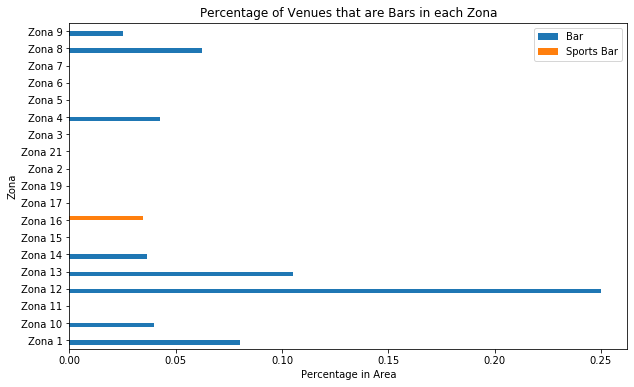

In [229]:
bars.plot(kind='barh', figsize=(10, 6))

plt.xlabel('Percentage in Area') # add to x-label to the plot
plt.ylabel('Zona') # add y-label to the plot
plt.title('Percentage of Venues that are Bars in each Zona') # add title to the plot

plt.show()